<a href="https://www.kaggle.com/code/busranasir/mlp-on-cifar-10?scriptVersionId=226454871" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv("/kaggle/input/cifar10-python-in-csv/train.csv")

In [3]:
train_data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_3063,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,label
0,59,43,50,68,98,119,139,145,149,149,...,58,65,59,46,57,104,140,84,72,6
1,154,126,105,102,125,155,172,180,142,111,...,42,67,101,122,133,136,139,142,144,9
2,255,253,253,253,253,253,253,253,253,253,...,83,80,69,66,72,79,83,83,84,9
3,28,37,38,42,44,40,40,24,32,43,...,39,59,42,44,48,38,28,37,46,4
4,170,168,177,183,181,177,181,184,189,189,...,88,85,82,83,79,78,82,78,80,1


In [4]:
x=train_data.drop(["label"], axis=1)

In [5]:
x.shape

(50000, 3072)

In [6]:
y = train_data["label"]

In [7]:
y

0        6
1        9
2        9
3        4
4        1
        ..
49995    2
49996    6
49997    9
49998    1
49999    1
Name: label, Length: 50000, dtype: int64

In [8]:
import matplotlib.pyplot as plt


In [9]:
x=x.values

In [10]:
y=y.astype(int).values

In [11]:
type(y)

numpy.ndarray

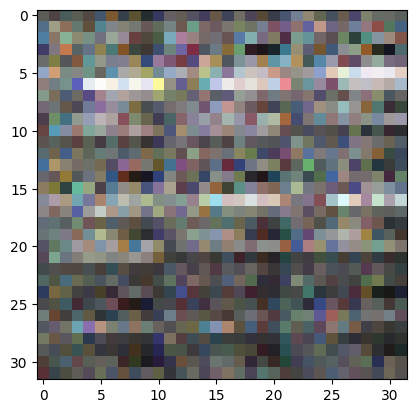

In [12]:
plt.imshow(x[98].reshape(32,32,3))

In [13]:
x = ((x / 255) - 0.5) * 2  #change pixel value from-1to1

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_temp, x_test, y_temp, y_test = train_test_split(
    x, y, test_size=10000, random_state=123, stratify=y)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del x_temp, y_temp

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=10000, random_state=123, stratify=y)

# Print the shapes of the splits
print(f"Training set: x_train={x_train.shape}, y_train={y_train.shape}")
print(f"Test set: x_test={x_test.shape}, y_test={y_test.shape}")

Training set: x_train=(40000, 3072), y_train=(40000,)
Test set: x_test=(10000, 3072), y_test=(10000,)


In [17]:
#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [18]:
#x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [19]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(40000, 3072)
(5000, 3072)
(10000, 3072)
(40000,)
(5000,)
(10000,)


In [20]:
y.shape[0]

50000

In [21]:
my_list = list(set(y))
my_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [22]:
my_list = []
for i in y:
    if i not in my_list:
        my_list.append(i)
    

In [23]:
sorted(my_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [24]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [25]:
model = NeuralNetMLP(num_features=32*32*3, num_hidden=50, num_classes=10)

## neural network training loop

In [26]:
num_epochs=100
minibatch_size=100

def minibatch_generator(x,y, minibatch_size):
    indices=np.arange(x.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0]-minibatch_size+1,minibatch_size):
        batch_idx=indices[start_idx:start_idx+minibatch_size]

        yield x[batch_idx], y[batch_idx]

# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        x_train, y_train, minibatch_size)
    
    for x_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(x_train_mini.shape)
print(y_train_mini.shape)
        

(100, 3072)
(100,)


In [27]:
def compute_mse_and_acc(nnet, x, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(x, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [28]:
def train(model, x_train, y_train, x_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            x_train, y_train, minibatch_size)

        for x_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(x_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(x_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, x_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, x_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [29]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, x_train, y_train, x_test, y_test,
    num_epochs=400, learning_rate=0.1)

Epoch: 001/400 | Train MSE: 0.08 | Train Acc: 27.84% | Valid Acc: 28.17%
Epoch: 002/400 | Train MSE: 0.08 | Train Acc: 31.94% | Valid Acc: 32.01%
Epoch: 003/400 | Train MSE: 0.08 | Train Acc: 34.17% | Valid Acc: 34.72%
Epoch: 004/400 | Train MSE: 0.08 | Train Acc: 35.44% | Valid Acc: 35.75%
Epoch: 005/400 | Train MSE: 0.08 | Train Acc: 36.70% | Valid Acc: 36.49%
Epoch: 006/400 | Train MSE: 0.08 | Train Acc: 37.50% | Valid Acc: 37.35%
Epoch: 007/400 | Train MSE: 0.08 | Train Acc: 38.24% | Valid Acc: 38.29%
Epoch: 008/400 | Train MSE: 0.08 | Train Acc: 38.85% | Valid Acc: 38.92%
Epoch: 009/400 | Train MSE: 0.07 | Train Acc: 39.59% | Valid Acc: 39.46%
Epoch: 010/400 | Train MSE: 0.07 | Train Acc: 40.09% | Valid Acc: 39.89%
Epoch: 011/400 | Train MSE: 0.07 | Train Acc: 40.41% | Valid Acc: 40.21%
Epoch: 012/400 | Train MSE: 0.07 | Train Acc: 41.23% | Valid Acc: 40.55%
Epoch: 013/400 | Train MSE: 0.07 | Train Acc: 41.51% | Valid Acc: 41.07%
Epoch: 014/400 | Train MSE: 0.07 | Train Acc: 41.96

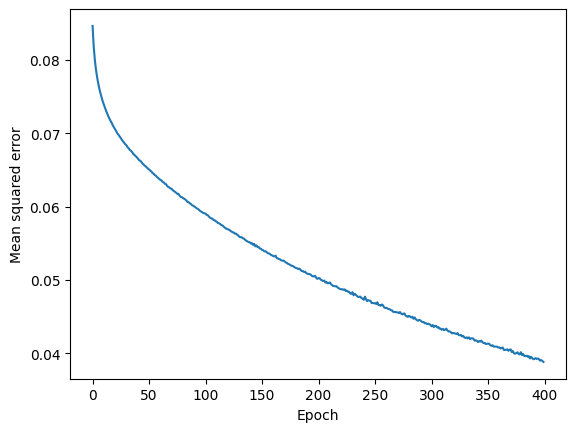

In [30]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

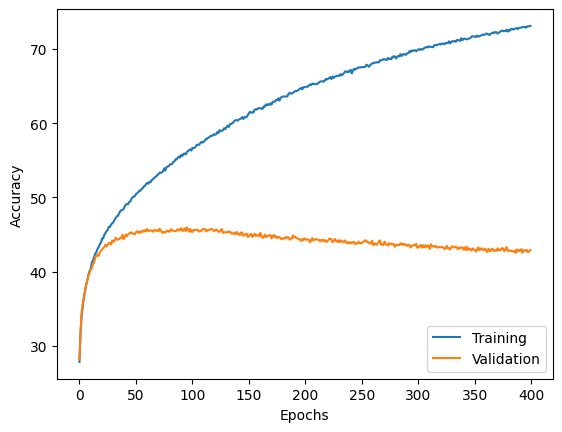

In [31]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [32]:
test_mse, test_acc = compute_mse_and_acc(model, x_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 42.91%


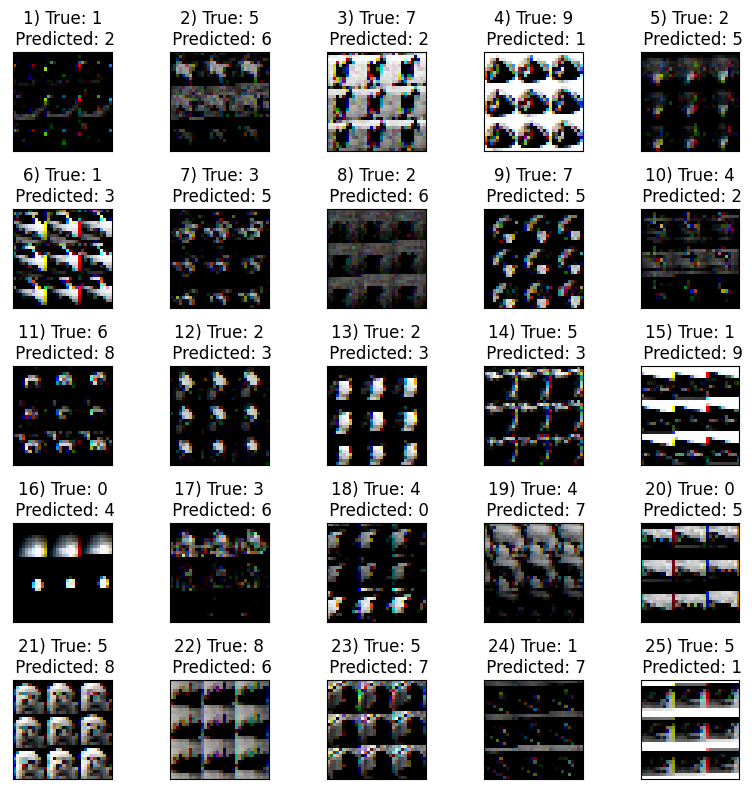

In [33]:
x_test_subset = x_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(x_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = x_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(32, 32, 3)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()